In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None

In [4]:
weight = 'weight_kg'
pos = 'player_positions'
limit_val = 0.9

In [5]:
data = pd.read_csv("players_20.csv", index_col=2)
data

,sofifa_id,player_url,long_name,age,dob,height_cm,weight_kg,nationality,club,overall,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
short_name,,,,,,,,,,,,,,,,,,,,,
L. Messi,158023,https://sofifa.com/player/158023/lionel-messi/...,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,94,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
Cristiano Ronaldo,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,93,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
Neymar Jr,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,92,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
J. Oblak,200389,https://sofifa.com/player/200389/jan-oblak/20/...,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E. Hazard,183277,https://sofifa.com/player/183277/eden-hazard/2...,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,91,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shao Shuai,245006,https://sofifa.com/player/245006/shuai-shao/20...,邵帅,22,1997-03-10,186,79,China PR,Beijing Renhe FC,48,...,43+2,42+2,42+2,42+2,43+2,45+2,46+2,46+2,46+2,45+2
Xiao Mingjie,250995,https://sofifa.com/player/250995/mingjie-xiao/...,Mingjie Xiao,22,1997-01-01,177,66,China PR,Shanghai SIPG FC,48,...,44+2,43+2,43+2,43+2,44+2,46+2,47+2,47+2,47+2,46+2
Zhang Wei,252332,https://sofifa.com/player/252332/wei-zhang/20/...,张威,19,2000-05-16,186,75,China PR,Hebei China Fortune FC,48,...,47+2,49+2,49+2,49+2,47+2,47+2,49+2,49+2,49+2,47+2


### Задача
Нужно выполнить классификацию признака "player_positions", которая является позицией игроков в fifa 20 на футбольном поле

In [6]:
data[pos].head()

short_name
L. Messi             RW, CF, ST
Cristiano Ronaldo        ST, LW
Neymar Jr               LW, CAM
J. Oblak                     GK
E. Hazard                LW, CF
Name: player_positions, dtype: object

### Описание данных
Данные представляют собой игровые характеристики футболистов в fifa 20.  
Опишем далее наиболее важные признаки представленных в датасете игроков:  

| признак  | описание |
| ------------- | ------------- |
| long_name  | полное имя игрока  |
| age  | возраст игрока  |
| dob  | дата рождения  |
| height_cm  | высота игрока в сантиметрах  |
| weight_kg  | вес игрока в килограммах  |
| nationality  | национальность игрока  |
| club  | клуб за который выступает игрок  |
| overall  | итоговая характеристика игрока (из 100 возможных пунктов) |
| value_eur  | ценновая стоимость игрока в Евро |
| wage_eur  | зарплата игрока в клубе |
| player_positions  | позиция игрока на футбольном поле |
| wage_eur  | зарплата игрока в клубе |
| wage_eur  | зарплата игрока в клубе |
|team_jersey_number|номер игрока|
|joined|с какого момента игрок выступает за клуб|
|contract_valid_until|дата окончания контракта игрока с клубом|
|**pace, power_jumping, defending_marking, ...**|**физические характеристики игрока**|

### Обработка данных
В нашем датасете есть немало ненужных признаков, поэтому перед обработкой данных необходимо удалить признаки, не имеющие для нас никакой ценности.  
Помимо этого, мы обьединим классы в 4 суперкласса, отвечающие за 4 основные позиции на футбольном поле, а именно:  
`вратать`, `защитник`, `полузащитник`, `нападающий`

In [7]:
# выведем все признаки
print(data.columns.tolist())

['sofifa_id', 'player_url', 'long_name', 'age', 'dob', 'height_cm', 'weight_kg', 'nationality', 'club', 'overall', 'potential', 'value_eur', 'wage_eur', 'player_positions', 'preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', 'nation_position', 'nation_jersey_number', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'pow

In [8]:
# удалим ненужные признаки, оставив физические характеристики игрока, его имя, вес и конкретную позицию на футбольном поле
data = data.drop(['sofifa_id', 'player_url', 'long_name', 'age', 'dob', 'height_cm', \
                  'nationality', 'club', 'overall', 'potential', 'value_eur', \
                  'wage_eur'], axis=1
                )
data = data.drop(['preferred_foot', 'international_reputation', 'weak_foot', 'skill_moves', \
                  'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', \
                  'team_position', 'team_jersey_number', 'loaned_from', 'joined', 'contract_valid_until', \
                  'nation_position', 'nation_jersey_number', 'player_traits'], axis=1
                )
data = data.drop(['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', \
                  'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', \
                  'cb', 'rcb', 'rb'], axis=1
                )

# удалим и заполнили нулями NaN'ы
data = data[data[pos].notna()]
data = data.fillna(0)

print(data.columns.tolist())

['weight_kg', 'player_positions', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']


In [9]:
# обьединим классы в 4 суперкласса
striker    = np.array(['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW'])
defender   = np.array(['LWB', 'LDM', 'FDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'CDM'])
midfielder = np.array(['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM'])
goalkeeper = np.array(['GK'])

for i in range(len(data[pos])):
    player = data[pos][i].split(',')[0]
    if player in striker:
        data[pos][i] = 'striker'
    elif player in defender:
        data[pos][i] = 'defender'
    elif player in midfielder:
        data[pos][i] = 'midfielder'
    else:
        assert(player == 'GK')
        data[pos][i] = 'goalkeeper'
        
print(data[pos])
print("Количество суперклассов = ", len(data[pos].value_counts()))
print(data[pos].value_counts())

short_name
L. Messi                striker
Cristiano Ronaldo       striker
Neymar Jr               striker
J. Oblak             goalkeeper
E. Hazard               striker
                        ...    
Shao Shuai             defender
Xiao Mingjie           defender
Zhang Wei            midfielder
Wang Haijian         midfielder
Pan Ximing           midfielder
Name: player_positions, Length: 18278, dtype: object
Количество суперклассов =  4
defender      7362
midfielder    5438
striker       3442
goalkeeper    2036
Name: player_positions, dtype: int64


In [10]:
data[pos].value_counts()

defender      7362
midfielder    5438
striker       3442
goalkeeper    2036
Name: player_positions, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18278 entries, L. Messi to Pan Ximing
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weight_kg                   18278 non-null  int64  
 1   player_positions            18278 non-null  object 
 2   pace                        18278 non-null  float64
 3   shooting                    18278 non-null  float64
 4   passing                     18278 non-null  float64
 5   dribbling                   18278 non-null  float64
 6   defending                   18278 non-null  float64
 7   physic                      18278 non-null  float64
 8   gk_diving                   18278 non-null  float64
 9   gk_handling                 18278 non-null  float64
 10  gk_kicking                  18278 non-null  float64
 11  gk_reflexes                 18278 non-null  float64
 12  gk_speed                    18278 non-null  float64
 13  gk_positioning          

In [12]:
LE = preprocessing.LabelEncoder()

In [13]:
LE.fit(data[pos])
data[pos] = LE.transform(data[pos])

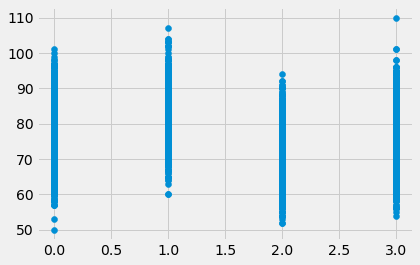

In [14]:
plt.scatter(data[pos], data[weight])

### Работа с выбросами

In [15]:
data[weight]

short_name
L. Messi             72
Cristiano Ronaldo    83
Neymar Jr            68
J. Oblak             87
E. Hazard            74
                     ..
Shao Shuai           79
Xiao Mingjie         66
Zhang Wei            75
Wang Haijian         74
Pan Ximing           78
Name: weight_kg, Length: 18278, dtype: int64

In [16]:
data[weight].quantile([0.005, 0.5, 0.995])

0.005    59.0
0.500    75.0
0.995    94.0
Name: weight_kg, dtype: float64

In [17]:
# удалим игроков, которые выходят за пределы квантилей 0.005 и 0.995
drop_players = data[(data[weight] < data[weight].quantile(0.005)) |
                    (data[weight] > data[weight].quantile(0.995))].index
data = data.drop(drop_players)
print(data.shape)

(18082, 48)


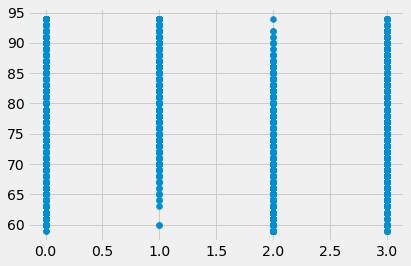

In [18]:
plt.scatter(data[pos], data[weight])

### Визуализация данных и описательная статистика

In [19]:
data.describe()

,weight_kg,player_positions,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,...,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000,18082.000000
mean,75.250304,1.269882,60.271154,46.551930,50.958190,55.665856,45.931921,57.787966,7.174704,6.927829,...,48.428492,58.554972,46.941323,47.740792,45.700088,16.475390,16.266066,16.124544,16.274693,16.610275
std,6.789531,1.176033,23.682721,21.039224,20.417254,21.823544,22.357263,22.257640,20.590550,19.873622,...,15.677591,11.864461,20.069252,21.558725,21.193631,17.606807,16.879099,16.507807,17.006134,17.904293
min,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,12.000000,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,70.000000,0.000000,57.000000,35.000000,46.000000,53.000000,31.000000,55.000000,0.000000,0.000000,...,39.000000,51.000000,29.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,75.000000,1.000000,67.000000,52.000000,56.000000,62.000000,53.000000,65.000000,0.000000,0.000000,...,49.000000,60.000000,52.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,80.000000,2.000000,74.000000,62.000000,64.000000,69.000000,64.000000,71.000000,0.000000,0.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,94.000000,3.000000,96.000000,93.000000,92.000000,96.000000,90.000000,90.000000,90.000000,92.000000,...,92.000000,96.000000,94.000000,92.000000,90.000000,90.000000,92.000000,93.000000,91.000000,92.000000


#### Корреляция между элементами

In [20]:
# вычислим матрицу корреляции для количественных признаков
corr_matr = data.corr()
corr_matr

,weight_kg,player_positions,pace,shooting,passing,dribbling,defending,physic,gk_diving,gk_handling,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
weight_kg,1.000000,-0.168174,-0.447721,-0.310092,-0.366788,-0.413748,-0.101639,-0.086152,0.334362,0.335248,...,-0.240796,-0.052880,-0.044587,-0.048530,-0.059735,0.333798,0.335592,0.332756,0.336227,0.334653
player_positions,-0.168174,1.000000,0.202009,0.486131,0.157358,0.261519,-0.483124,-0.063533,-0.079968,-0.080001,...,0.477007,0.126238,-0.562247,-0.604224,-0.632534,-0.082184,-0.079739,-0.078098,-0.080493,-0.078148
pace,-0.447721,0.202009,1.000000,0.793528,0.845598,0.909521,0.550485,0.779688,-0.886825,-0.887201,...,0.646803,0.442046,0.405720,0.383535,0.367141,-0.871413,-0.871372,-0.868490,-0.870095,-0.872499
shooting,-0.310092,0.486131,0.793528,1.000000,0.879776,0.911048,0.382933,0.709946,-0.771024,-0.771351,...,0.878666,0.632141,0.244145,0.197982,0.158974,-0.754964,-0.753297,-0.750020,-0.750573,-0.753531
passing,-0.366788,0.157358,0.845598,0.879776,1.000000,0.962868,0.684615,0.826108,-0.869715,-0.870083,...,0.750132,0.670503,0.560453,0.537040,0.506583,-0.851647,-0.850091,-0.847924,-0.847544,-0.851474
dribbling,-0.413748,0.261519,0.909521,0.911048,0.962868,1.000000,0.595052,0.809623,-0.888840,-0.889217,...,0.772898,0.624338,0.456071,0.425540,0.396908,-0.872002,-0.870604,-0.868247,-0.868303,-0.872033
defending,-0.101639,-0.483124,0.550485,0.382933,0.684615,0.595052,1.000000,0.814866,-0.715906,-0.716210,...,0.277510,0.458917,0.948057,0.960212,0.944267,-0.699265,-0.699565,-0.697801,-0.695996,-0.701089
physic,-0.086152,-0.063533,0.779688,0.709946,0.826108,0.809623,0.814866,1.000000,-0.904729,-0.905112,...,0.587084,0.549598,0.685789,0.670076,0.639221,-0.885002,-0.884183,-0.881550,-0.880390,-0.885241
gk_diving,0.334362,-0.079968,-0.886825,-0.771024,-0.869715,-0.888840,-0.715906,-0.904729,1.000000,0.997628,...,-0.637330,-0.431047,-0.557276,-0.545595,-0.523289,0.985390,0.981831,0.978424,0.980849,0.984613
gk_handling,0.335248,-0.080001,-0.887201,-0.771351,-0.870083,-0.889217,-0.716210,-0.905112,0.997628,1.000000,...,-0.638477,-0.431874,-0.557738,-0.545996,-0.523685,0.982538,0.984542,0.978488,0.981233,0.982988


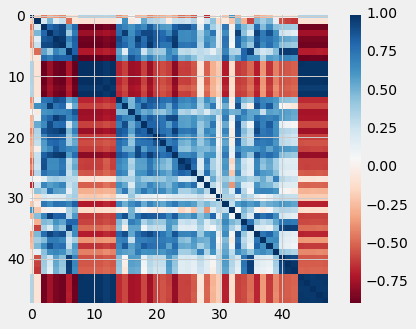

In [21]:
# построим тепловую карту
fig, ax = plt.subplots()

c = ax.imshow(corr_matr, cmap='RdBu', interpolation='nearest', aspect='auto')
fig.colorbar(c, ax = ax)
fig.set_figwidth(6)
fig.set_figheight(5)

plt.show()

In [22]:
# определим коррелирующие между собой признаки
corr_features = set()
for i in range(len(corr_matr.columns)): 
    for j in range(i): 
        if abs(corr_matr.iloc[i, j]) > limit_val:
            colname = corr_matr.columns[i]
            corr_features.add(colname)
            
print(corr_features)

{'goalkeeping_diving', 'mentality_interceptions', 'defending_sliding_tackle', 'gk_handling', 'goalkeeping_kicking', 'attacking_finishing', 'attacking_short_passing', 'defending_marking', 'skill_dribbling', 'gk_reflexes', 'dribbling', 'goalkeeping_reflexes', 'gk_speed', 'attacking_volleys', 'goalkeeping_handling', 'defending_standing_tackle', 'movement_sprint_speed', 'gk_kicking', 'mentality_positioning', 'gk_diving', 'skill_ball_control', 'power_long_shots', 'gk_positioning', 'goalkeeping_positioning'}


In [23]:
# удалим их 
data = data.drop(labels=corr_features, axis=1)

### Обучающая и тестовая выборки

In [24]:
y = data[pos]
x = data.drop(pos, axis=1)

#### Нормализация количественных признаков

In [25]:
x_std = (x - x.mean(axis=0)) / x.std(axis=0)
x_std.describe()

,weight_kg,pace,shooting,passing,defending,physic,attacking_crossing,attacking_heading_accuracy,skill_curve,skill_fk_accuracy,...,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,mentality_aggression,mentality_vision,mentality_penalties,mentality_composure
count,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,...,18082.000000,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04,1.808200e+04
mean,-5.532818e-16,1.257459e-16,1.760442e-16,1.886188e-16,-4.401105e-17,1.131713e-16,1.760442e-16,7.544752e-17,1.131713e-16,1.257459e-17,...,0.000000,2.514917e-17,2.011934e-16,-4.401105e-17,1.634696e-16,5.029835e-17,2.514917e-17,1.005967e-16,-8.802211e-17,2.514917e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.393435e+00,-2.544942e+00,-2.212626e+00,-2.495840e+00,-2.054452e+00,-2.596320e+00,-2.450863e+00,-2.726146e+00,-2.249605e+00,-2.225559e+00,...,-4.464005,-3.690479e+00,-3.315086e+00,-3.864545e+00,-3.191892e+00,-3.649901e+00,-2.708323e+00,-3.199759e+00,-2.642529e+00,-3.923901e+00
25%,-7.732941e-01,-1.381241e-01,-5.490664e-01,-2.428432e-01,-6.678779e-01,-1.252588e-01,-6.458838e-01,-4.208784e-01,-7.278612e-01,-6.755604e-01,...,-0.630834,-5.611130e-01,-7.648846e-01,-5.867510e-01,-4.366927e-01,-5.854931e-01,-6.831677e-01,-6.912594e-01,-6.013993e-01,-6.367733e-01
50%,-3.686619e-02,2.841247e-01,2.589482e-01,2.469387e-01,3.161424e-01,3.240251e-01,2.292576e-01,2.130703e-01,8.735897e-02,-1.014868e-01,...,0.026280,1.501066e-01,6.018063e-02,8.561704e-02,1.894891e-01,5.964553e-02,1.268942e-01,9.712622e-02,3.645379e-02,1.217947e-01
75%,6.995617e-01,5.796989e-01,7.342509e-01,6.387641e-01,8.081525e-01,5.935955e-01,7.762209e-01,6.741239e-01,7.938831e-01,7.596237e-01,...,0.683395,7.190822e-01,7.352340e-01,6.739390e-01,6.904345e-01,7.047841e-01,7.633714e-01,7.421690e-01,7.380922e-01,7.117920e-01
max,2.761560e+00,1.508646e+00,2.207689e+00,2.010153e+00,1.971086e+00,1.447235e+00,2.362415e+00,2.345443e+00,2.533019e+00,2.941103e+00,...,3.749932,2.354887e+00,2.760394e+00,2.522951e+00,2.130652e+00,2.398273e+00,2.267772e+00,2.892311e+00,2.779222e+00,3.156067e+00


In [26]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2, stratify=y, random_state=42)

### KNN и получившиеся оценки

In [27]:
kn_clf_5  = KNeighborsClassifier(n_neighbors=5)
kn_clf_10 = KNeighborsClassifier(n_neighbors=10)
kn_clf_15 = KNeighborsClassifier(n_neighbors=15)

kn_clf_5.fit(x_train.values, y_train.values)
kn_clf_10.fit(x_train.values, y_train.values)
kn_clf_15.fit(x_train.values, y_train.values)

KNeighborsClassifier(n_neighbors=15)

In [28]:
y_pred_test_5  = kn_clf_5.predict(x_test.values)
y_pred_test_10 = kn_clf_10.predict(x_test.values)
y_pred_test_15 = kn_clf_15.predict(x_test.values)

y_pred_train_5  = kn_clf_5.predict(x_train.values)
y_pred_train_10 = kn_clf_10.predict(x_train.values)
y_pred_train_15 = kn_clf_15.predict(x_train.values)

In [29]:
print("f1_score for 5 neighbors  test = ", f1_score(y_test.values, y_pred_test_5,  average='macro'))
print("f1_score for 10 neighbors test = ", f1_score(y_test.values, y_pred_test_10, average='macro'))
print("f1_score for 15 neighbors test = ", f1_score(y_test.values, y_pred_test_15, average='macro'))
print()
print("f1_score for 5 neighbors  train = ", f1_score(y_train.values, y_pred_train_5,  average='macro'))
print("f1_score for 10 neighbors train = ", f1_score(y_train.values, y_pred_train_10, average='macro'))
print("f1_score for 15 neighbors train = ", f1_score(y_train.values, y_pred_train_15, average='macro'))

f1_score for 5 neighbors  test =  0.8615756060880294
f1_score for 10 neighbors test =  0.8649131005213899
f1_score for 15 neighbors test =  0.8705270103218594

f1_score for 5 neighbors  train =  0.9024079128913088
f1_score for 10 neighbors train =  0.8888966339953505
f1_score for 15 neighbors train =  0.8868434452068394


### Выводы

Метод KNN хорошо справился со своей задачей, показав отличные результаты.  
Результаты можно еще больше улучшить, подобрав и настроив гиперпараметры.

## Обучение нейронной сети

### Настройка гиперпараметров

In [30]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100, 2), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=800, random_state = 42)
    mlp_model.fit(x_train, y_train)

    y_train_pred = mlp_model.predict(x_train)
    y_test_pred = mlp_model.predict(x_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(f1_score(y_train, y_train_pred, average='macro'))
    test_acc.append(f1_score(y_test, y_test_pred, average='macro'))

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:

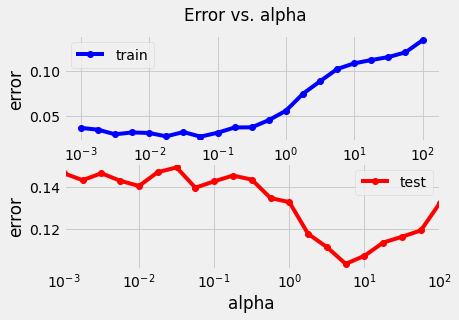

In [31]:
fig, axs = plt.subplots(2)
fig.suptitle('Error vs. alpha')

axs[0].semilogx(alpha_arr, train_err, 'b-o', label = 'train')
axs[0].set_ylabel('error')
axs[0].legend()

axs[1].semilogx(alpha_arr, test_err, 'r-o', label = 'test')
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('error')
axs[1].legend()

plt.xlim([np.min(alpha_arr), np.max(alpha_arr)]);

### Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра

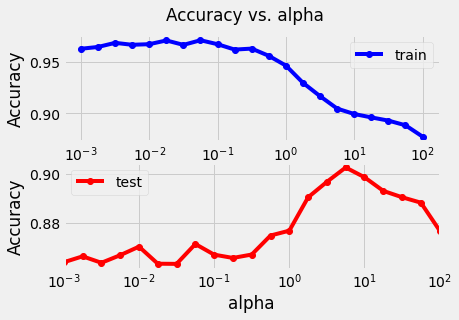

In [32]:
fig, axs = plt.subplots(2)
fig.suptitle('Accuracy vs. alpha')

axs[0].semilogx(alpha_arr, train_acc, 'b-o', label = 'train')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].semilogx(alpha_arr, test_acc, 'r-o', label = 'test')
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.xlim([np.min(alpha_arr), np.max(alpha_arr)]);

In [33]:
# Минимальное значение ошибки:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.027652955409609402 0.10312413602432956


In [34]:
# Оптимальные значения alpha:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[5.62341325]


In [35]:
alpha_opt = alpha_opt[0]

### Классификатор при найденном оптимальном значении alpha

In [36]:
# Повторим обучение:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100, 2),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(x_train, y_train)

y_train_pred = mlp_model.predict(x_train)
y_test_pred = mlp_model.predict(x_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.10542689249913585
0.10644180259883881


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Матрица рассогласования

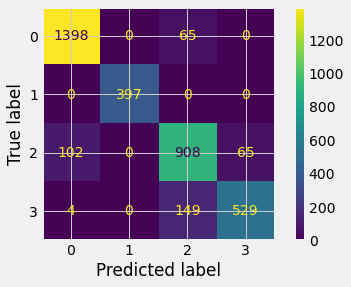

In [37]:
plot_confusion_matrix(mlp_model, x_test, y_test) 

### Получившиеся оценки

In [38]:
print("train error = ", np.mean(y_train != y_train_pred))
print("test error  = ", np.mean(y_test != y_test_pred))
print()
print("f1_score for train = ", f1_score(np.array(y_train), y_train_pred, average='macro'))
print("f1_score for test  = ", f1_score(np.array(y_test), y_test_pred, average='macro'))

train error =  0.10542689249913585
test error  =  0.10644180259883881

f1_score for train =  0.902000668869213
f1_score for test  =  0.8995253334065505


### Выводы

По полученным результатам можно сказать, что алгоритм одинаково отлично показывает себя на тестовой и обучемой выборках.
Это говорит об отсуствии перееобучения и недообучения. 

Стоит также отметить, что на рассматриваемых параметрах нейронная сеть с двумя скрытыми слоями относительно немного отличается по точности классификации относительно метода KNN, который был получен в предудщей домашней работе.

### Спасибо за внимание!

*Выполнил работу Сумин Игорь ПМИ группа 381803-1*